## Monitorización de experimentos (Wandb)

<a target="_blank" href="https://colab.research.google.com/github/pglez82/DeepLearningWeb/blob/master/labs/notebooks/Monitorizaci%C3%B3n%20de%20experimentos%20(Wandb).ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

La monitorización de experimentos es un aspecto muy importante en el aprendizaje profundo. Habitualmente probamos muchas configuraciones, modelos, etc. siendo totalmente necesario tener una herramienta que sea capaz de llevar cuenta de estos experimentos realizados y de sus resultados.

Una de estas herramientas es **Weights and Biases**. Weights and Biases nos permite tener un panel colaborativo donde almacenar todos nuestros experimentos.

Lo primero es ir a la página de [Weights and Biases](https://wandb.ai/site) y crear una cuenta (es gratuito).

### Instalación de los paquetes necesarios
El uso de Weights and Biases es muy sencillo. Solo requiere la instalación de un paquete.

In [1]:
!pip install wandb

### Definición de la red y carga de datos
Esta parte se hace como hasta ahora

In [2]:
import torch.nn as nn
import torchvision.transforms as T
import torch, torchvision

#Definición del modelo
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        self.model = nn.Sequential(nn.Flatten(),
                         nn.Linear(28*28, 256),
                         nn.BatchNorm1d(256),
                         nn.ReLU(),
                         nn.Dropout(dropout),
                         nn.Linear(256,10)).to(device)

    def forward(self, x):
        return self.model(x)

device = "cuda:0" if torch.cuda.is_available() else "cpu"


def get_dataloader(is_train, batch_size, slice=5):
    full_dataset = torchvision.datasets.MNIST(root=".", train=is_train, transform=T.ToTensor(), download=True)
    sub_dataset = torch.utils.data.Subset(full_dataset, indices=range(0, len(full_dataset), slice))
    loader = torch.utils.data.DataLoader(dataset=sub_dataset, batch_size=batch_size, shuffle=True if is_train else False, num_workers=2)
    return loader

### Bucles de validación y enternamiento usando wandb

Realmente los bucles de entrenamiento y validación son los mismos que siempre, lo único que tendremos que intercalar ciertas instrucciones para loguear los resultados en la plataforma de wandb.

In [3]:
import wandb
import math
import random

def validate_model(model, valid_dl, loss_func, log_images=False, batch_idx=0):
    model.eval()
    val_loss = 0.
    with torch.inference_mode():
        correct = 0
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            val_loss += loss_func(outputs, labels)*labels.size(0)

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    return val_loss / len(valid_dl.dataset), correct / len(valid_dl.dataset)

In [4]:
def train(config):
    # Get the data
    train_dl = get_dataloader(is_train=True, batch_size=config.batch_size)
    valid_dl = get_dataloader(is_train=False, batch_size=2*config.batch_size)
    n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)

    # A simple MLP model
    model = Net(config.dropout)
    model.to(device)

    # Make the loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

    example_ct = 0
    step_ct = 0
    for epoch in range(config.epochs):
        model.train()
        for step, (images, labels) in enumerate(train_dl):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            train_loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            example_ct += len(images)
            metrics = {"train/train_loss": train_loss,
                       "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch,
                       "train/example_ct": example_ct}

            if step + 1 < n_steps_per_epoch:
                # 🐝 Loguear las métricas de entrenamiento a wandb
                wandb.log(metrics)

            step_ct += 1

        val_loss, accuracy = validate_model(model, valid_dl, loss_func, log_images=(epoch==(config.epochs-1)))

        # 🐝 Loguear todas las métricas de validación a wandb
        val_metrics = {"val/val_loss": val_loss,
                       "val/val_accuracy": accuracy}
        wandb.log({**metrics, **val_metrics})

        print(f"Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")

    # 🐝 Acabar la ejecución del experimento
    wandb.finish()

### Lanzando diferentes experimentos

En este ejemplo vamos a lanzar 5 experimentos diferentes con diferentes dropouts. Todos ellos quedarán logueados en nuestro dashboard.

In [5]:
for experiment in range(5):
    # 🐝 Inicializar la ejecución de un experimento
    wandb.init(project="test-wandb", name="run_{}".format(experiment), config={
            "epochs": 10,
            "batch_size": 128,
            "lr": 1e-3,
            "dropout": random.uniform(0.01, 0.80),
            })

    # Cogemos la configuración de este experimento
    config = wandb.config
    train(config)

wandb: Currently logged in as: pglez82. Use `wandb login --relogin` to force relogin


Train Loss: 0.478, Valid Loss: 0.354432, Accuracy: 0.90
Train Loss: 0.422, Valid Loss: 0.286784, Accuracy: 0.92
Train Loss: 0.315, Valid Loss: 0.264495, Accuracy: 0.92
Train Loss: 0.477, Valid Loss: 0.239204, Accuracy: 0.92
Train Loss: 0.192, Valid Loss: 0.226562, Accuracy: 0.93
Train Loss: 0.153, Valid Loss: 0.217418, Accuracy: 0.93
Train Loss: 0.195, Valid Loss: 0.214587, Accuracy: 0.94
Train Loss: 0.190, Valid Loss: 0.204697, Accuracy: 0.93
Train Loss: 0.413, Valid Loss: 0.196016, Accuracy: 0.94
Train Loss: 0.251, Valid Loss: 0.195171, Accuracy: 0.94


train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▅▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▂▁▁▁▁▂▁▁▁▁▂
val/val_accuracy,▁▄▄▅▆▇▇▇█▇
val/val_loss,█▅▄▃▂▂▂▁▁▁
train/epoch,10.0
train/example_ct,120000
train/train_loss,0.25131
val/val_accuracy,0.9365
val/val_loss,0.19517


Train Loss: 0.252, Valid Loss: 0.278927, Accuracy: 0.92
Train Loss: 0.260, Valid Loss: 0.222845, Accuracy: 0.93
Train Loss: 0.295, Valid Loss: 0.198432, Accuracy: 0.94
Train Loss: 0.197, Valid Loss: 0.181576, Accuracy: 0.94
Train Loss: 0.082, Valid Loss: 0.174806, Accuracy: 0.94
Train Loss: 0.070, Valid Loss: 0.162808, Accuracy: 0.95
Train Loss: 0.069, Valid Loss: 0.156710, Accuracy: 0.95
Train Loss: 0.024, Valid Loss: 0.149423, Accuracy: 0.95
Train Loss: 0.046, Valid Loss: 0.152099, Accuracy: 0.95
Train Loss: 0.039, Valid Loss: 0.157897, Accuracy: 0.95


train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▅▃▄▂▃▃▂▂▂▂▂▁▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,▁▄▅▅▆█▇██▇
val/val_loss,█▅▄▃▂▂▁▁▁▁
train/epoch,10.0
train/example_ct,120000
train/train_loss,0.03906
val/val_accuracy,0.949
val/val_loss,0.1579


Train Loss: 0.350, Valid Loss: 0.275766, Accuracy: 0.92
Train Loss: 0.212, Valid Loss: 0.216804, Accuracy: 0.94
Train Loss: 0.089, Valid Loss: 0.181334, Accuracy: 0.94
Train Loss: 0.102, Valid Loss: 0.176733, Accuracy: 0.94
Train Loss: 0.098, Valid Loss: 0.162854, Accuracy: 0.95
Train Loss: 0.086, Valid Loss: 0.168279, Accuracy: 0.95
Train Loss: 0.063, Valid Loss: 0.159064, Accuracy: 0.95
Train Loss: 0.057, Valid Loss: 0.154974, Accuracy: 0.95
Train Loss: 0.034, Valid Loss: 0.161269, Accuracy: 0.95
Train Loss: 0.008, Valid Loss: 0.156871, Accuracy: 0.96


train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▅▃▃▂▂▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,▁▄▆▆▇▇▇▇▇█
val/val_loss,█▅▃▂▁▂▁▁▁▁
train/epoch,10.0
train/example_ct,120000
train/train_loss,0.00833
val/val_accuracy,0.9555
val/val_loss,0.15687


Train Loss: 0.301, Valid Loss: 0.308379, Accuracy: 0.91
Train Loss: 0.343, Valid Loss: 0.249213, Accuracy: 0.92
Train Loss: 0.330, Valid Loss: 0.225009, Accuracy: 0.93
Train Loss: 0.255, Valid Loss: 0.206980, Accuracy: 0.93
Train Loss: 0.121, Valid Loss: 0.196488, Accuracy: 0.94
Train Loss: 0.197, Valid Loss: 0.183816, Accuracy: 0.94
Train Loss: 0.253, Valid Loss: 0.179728, Accuracy: 0.94
Train Loss: 0.139, Valid Loss: 0.165384, Accuracy: 0.95
Train Loss: 0.091, Valid Loss: 0.162922, Accuracy: 0.95
Train Loss: 0.112, Valid Loss: 0.156249, Accuracy: 0.95


train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▅▄▄▃▂▂▂▃▂▂▂▁▂▂▂▂▁▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂
val/val_accuracy,▁▄▅▅▆▇▆██▇
val/val_loss,█▅▄▃▃▂▂▁▁▁
train/epoch,10.0
train/example_ct,120000
train/train_loss,0.11167
val/val_accuracy,0.9465
val/val_loss,0.15625


Train Loss: 0.179, Valid Loss: 0.294447, Accuracy: 0.91
Train Loss: 0.212, Valid Loss: 0.232958, Accuracy: 0.93
Train Loss: 0.173, Valid Loss: 0.203159, Accuracy: 0.94
Train Loss: 0.136, Valid Loss: 0.189992, Accuracy: 0.94
Train Loss: 0.217, Valid Loss: 0.179424, Accuracy: 0.95
Train Loss: 0.078, Valid Loss: 0.167579, Accuracy: 0.95
Train Loss: 0.104, Valid Loss: 0.160223, Accuracy: 0.94
Train Loss: 0.108, Valid Loss: 0.156833, Accuracy: 0.95
Train Loss: 0.040, Valid Loss: 0.154135, Accuracy: 0.95
Train Loss: 0.075, Valid Loss: 0.156363, Accuracy: 0.95


train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▅▃▃▃▂▃▂▂▂▂▂▂▃▂▂▂▁▁▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁
val/val_accuracy,▁▄▅▆▇▇▇█▇█
val/val_loss,█▅▃▃▂▂▁▁▁▁
train/epoch,10.0
train/example_ct,120000
train/train_loss,0.07477
val/val_accuracy,0.9525
val/val_loss,0.15636


### Resultados
En el portal wandb.ai puedes ver los resultados de los experimentos:
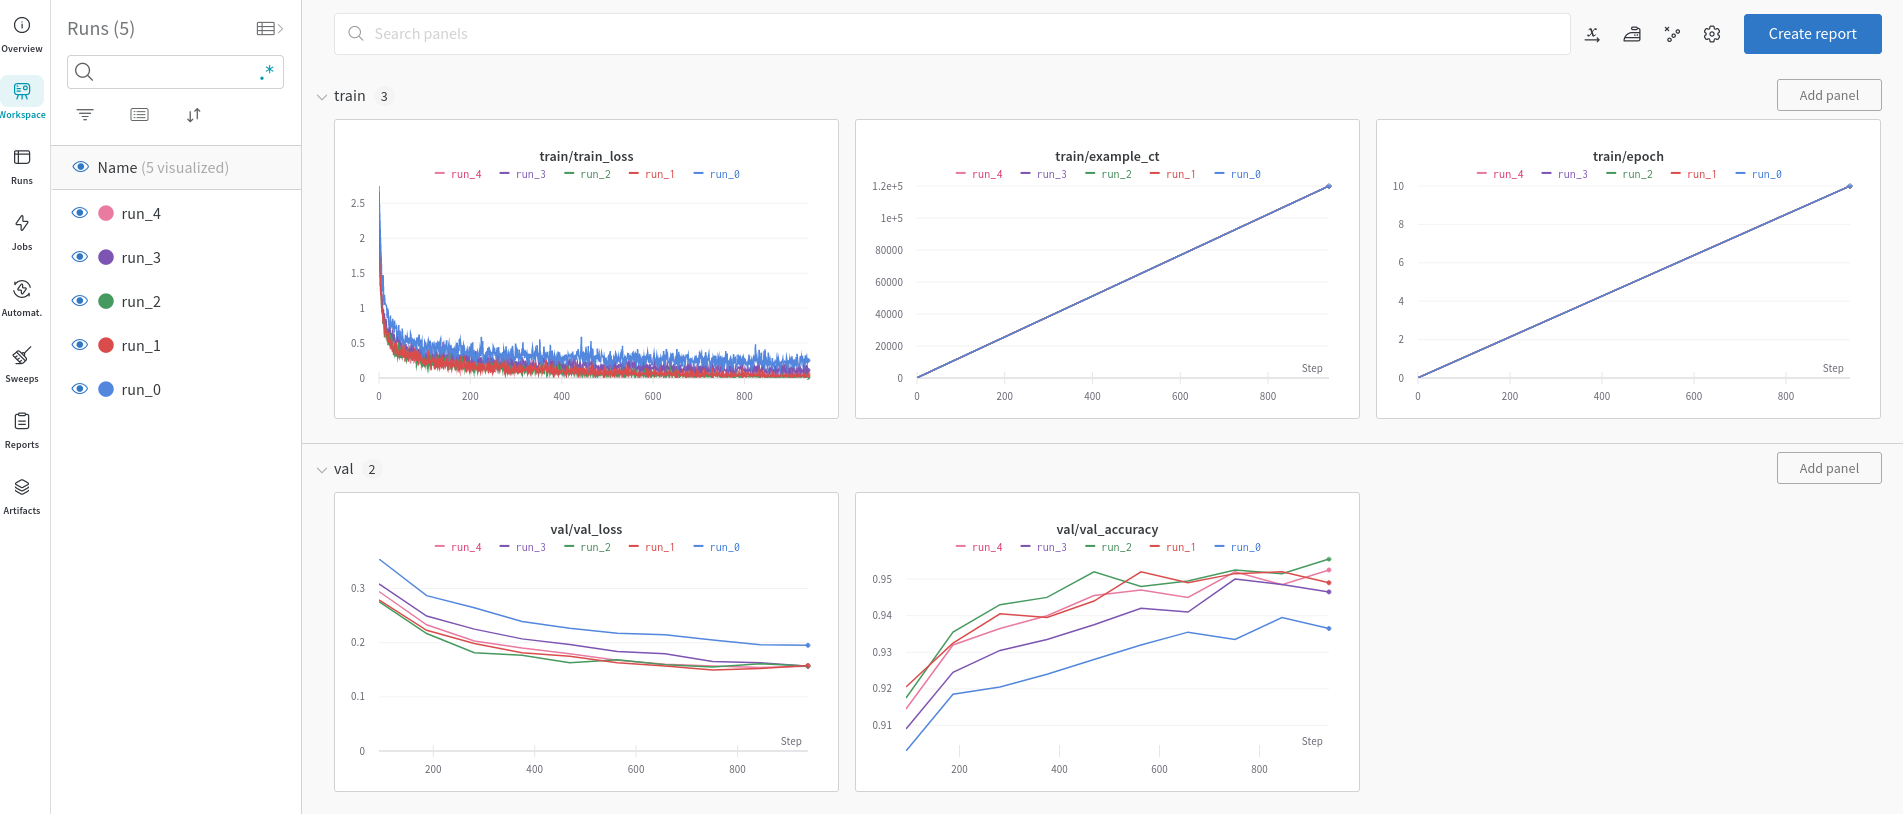